# FORECASTING USING MOVING AVERAGE MODEL

_**Consider appropriate time-series dataset and forecast using a moving average model.**_

In [1]:
# Imports packages

import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, AutoDateLocator

In this experiment, the following naive approaches will be used to create baselines models to forecast the quarterly EPS of Johnson & Johnson.

1) Historical mean of the entire train set
2) Historical mean of the last year in the train set
3) Last known value of the train set
4) Naive seasonality


### Retrieving & Analyzing the Data

The dataset that was considered in this experiment represents the quarterly earnings per share (EPS) in US dollars of Johnson & Johnson stock from 1960 to 1980.

In [2]:
# Loads the dataset
eps = pd.read_csv("../Data/time-series/johnson_&_johnson_stock_EPS.csv")

# Shows few instances from top
display(eps.head())

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [3]:
# Shows few instances from bottom
display(eps.tail())

,date,data
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02
83,1980-10-01,11.61


In [4]:
# Checks the shape of the dataset
print(eps.shape)

(84, 2)


In [5]:
# Checks the descriptive statistics of the dataset
print(eps.describe())

            data
count  84.000000
mean    4.799762
std     4.309991
min     0.440000
25%     1.247500
50%     3.510000
75%     7.132500
max    16.200000


Text(0.5, 1.0, 'Quarterly EPS of Johnson & Johnson')

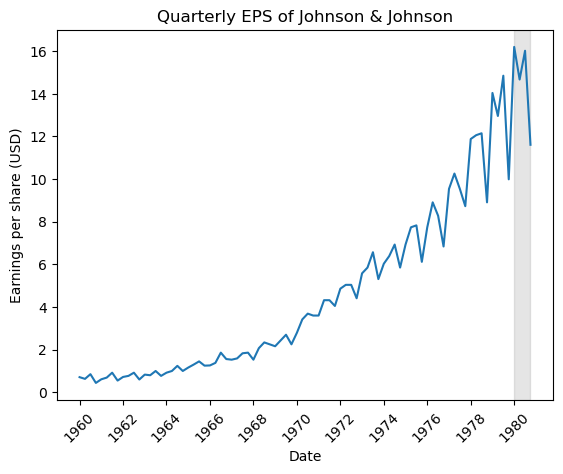

In [6]:
# Plots the dataset to visualize it

plt.plot(eps['date'], eps['data'])
plt.xlabel('Date')
plt.ylabel('Earnings per share (USD)')
plt.xticks(
    np.arange(0, 81, 8),                                                # Sets the location of the ticks
    [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980], # Sets the labels for each tick location
    rotation=45                                                         # Rotates the tick labels (at given degree) to enhance ligibility
)
plt.axvspan(80, 83, color='#808080', alpha=0.2)   # Highlights forecasting region
plt.title("Quarterly EPS of Johnson & Johnson")   # Sets plot title

The forecasting period is illustrated by the gray zone in above figure.

**Below ones are the findings out of the above figure.**
1. It has a trend since EPS is increasing over time.
2. There is a seasonality, since there are peaks and troughs (a low point between two high points) repeated over the course of a year, or four quarters.

### Preparing Datasets

In [7]:
# Splits data into train and test set.

X_train = eps[:-4]    # Contain EPS data for all quarters except the last four.
X_test = eps[-4:]     # Contains the EPS data only the last four quarters.

In [8]:
# Checks the train dataset

display(X_train)

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61
...,...,...
75,1978-10-01,8.91
76,1979-01-01,14.04
77,1979-04-02,12.96
78,1979-07-02,14.85


In [9]:
# Checks the test dataset

display(X_test)

,date,data
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02
83,1980-10-01,11.61


### Forecasting using Historical  Mean of the Entire Train Set
It simply computes the mean of the values over a certain period and assume that future values will be equal to that mean. In the context of predicting the EPS for Johnson & Johnson, the assumption will be like 

_The average EPS between 1960 and 1979 was USD 4.31. Therefore, it is expected that the EPS over the next four quarters of 1980to be equal to USD 4.31 per quarter._

In [10]:
# Calculates the historical mean of the entire train set
hist_mean = np.mean(X_train['data'])

print("$", round(hist_mean,2))

$ 4.31


This means that from 1960 to the end of 1979, the quarterly EPS of Johnson & Johnson was **\$4.31** on average.

In [11]:
# Creates a new column that holds the historical mean of the train set 
# to naively forecast this value for each quarter of 1980.

X_test.loc[:, "forecast_mean"] = hist_mean

display(X_test)

/tmp/ipykernel_325053/445827354.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, "forecast_mean"] = hist_mean


,date,data,forecast_mean
80,1980-01-01,16.20,4.3085
81,1980-04-01,14.67,4.3085
82,1980-07-02,16.02,4.3085
83,1980-10-01,11.61,4.3085


In [12]:
# Evaluates forecasting performance
hist_mean_mape = mean_absolute_percentage_error(X_test["data"], X_test["forecast_mean"])

print(round(hist_mean_mape,2))

0.7


Text(0.5, 1.0, 'Forecasting using Historical Mean.')

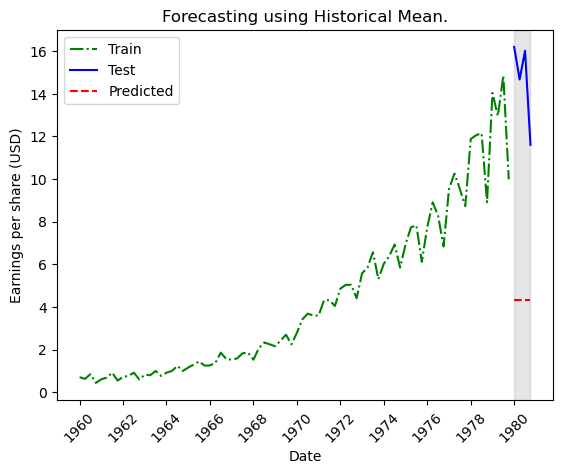

In [13]:
# Plots the forecasting

plt.plot(X_train['date'], X_train['data'], 'g-.', label='Train')
plt.plot(X_test['date'], X_test['data'], 'b-', label='Test')
plt.plot(X_test['date'], X_test['forecast_mean'], 'r--', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Earnings per share (USD)')
plt.axvspan(80, 83, color='#808080', alpha=0.2)
plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980], rotation=45)
plt.legend()
plt.title("Forecasting using Historical Mean.")


### Forecasting using Last Year's Mean

It was found that forecasting using entire historical mean did not do well because earlier values do not seem to be predictive of future values in the long term because of the positive trend component in the dataset. Earlier values are too small to be representative of the new level the EPS reaches toward the end of 1979 and onwards. The followings experiment by taking the mean of the last year in the training set to forecast each quarter in the following year. The assumption will be like

_If the EPS is USD 0.71 for this quarter, then the EPS will also be USD 0.71 for next quarter._

In [14]:
# Calculates the mean of the four quarters in last year [1979] in train set 
last_year_mean = np.mean(X_train.data[-4:])

print("$", round(last_year_mean, 2))

$ 12.96


In [15]:
# Creates a new column that holds the mean of the last 4 quarters 
# in 1979 to naively forecast this value for each quarter of 1980.

X_test.loc[:, 'forecast_last_year_mean'] = last_year_mean

/tmp/ipykernel_325053/1630128810.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, 'forecast_last_year_mean'] = last_year_mean


In [16]:
display(X_test)

,date,data,forecast_mean,forecast_last_year_mean
80,1980-01-01,16.20,4.3085,12.96
81,1980-04-01,14.67,4.3085,12.96
82,1980-07-02,16.02,4.3085,12.96
83,1980-10-01,11.61,4.3085,12.96


In [17]:
# Evaluates forecasting performance
last_year_mean_mape = mean_absolute_percentage_error(X_test["data"], X_test["forecast_last_year_mean"])

print(last_year_mean_mape)

0.155963680725103


Text(0.5, 1.0, 'Forecasting using the Last Year Mean.')

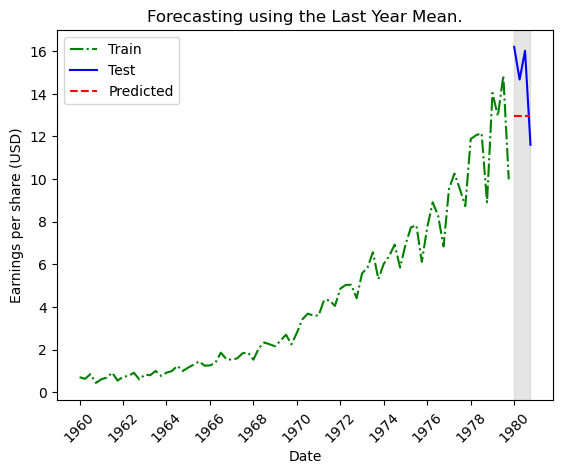

In [18]:
# Plots the forecasting

plt.plot(X_train['date'], X_train['data'], 'g-.', label='Train')
plt.plot(X_test['date'], X_test['data'], 'b-', label='Test')
plt.plot(X_test['date'], X_test['forecast_last_year_mean'], 'r--', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Earnings per share (USD)')
plt.axvspan(80, 83, color='#808080', alpha=0.2)
plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980], rotation=45)
plt.legend()
plt.title("Forecasting using the Last Year Mean.")


This new simple baseline is a clear improvement over the previous one as MAPE was decreased from 70% to 15.6%.

### Forecasting using Last Known Value

As best baseline has been the mean of the last recorded year in our training set, the next hypothesis that could be tested is that using the last known value of the training set as a baseline model if it provides better forecasts. The assumption will be like

_If the EPS is dollar 9.99 for the last quarter of 1979, then the EPS will also be dollar 9.99 for next four quarters._

In [19]:
# Gets the last known value of the train set, which corresponds to the EPS for the last quarter of 1979.
last_value = X_train.data.iloc[-1]

print("$", round(last_value, 2))

$ 9.99


In [20]:
# Creates a new column that holds the the last value of the last 4 quarter
# in 1979 to naively forecast this value for each quarter of 1980.

X_test.loc[:, 'forecast_last_value'] = last_value

/tmp/ipykernel_325053/899375005.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, 'forecast_last_value'] = last_value


In [21]:
display(X_test)

,date,data,forecast_mean,forecast_last_year_mean,forecast_last_value
80,1980-01-01,16.20,4.3085,12.96,9.99
81,1980-04-01,14.67,4.3085,12.96,9.99
82,1980-07-02,16.02,4.3085,12.96,9.99
83,1980-10-01,11.61,4.3085,12.96,9.99


In [22]:
# Evaluates forecasting performance
last_value_mape = mean_absolute_percentage_error(X_test["data"], X_test["forecast_last_value"])

print(last_value_mape)

0.30457277908606534


Text(0.5, 1.0, 'Forecasting using the Last Known Value.')

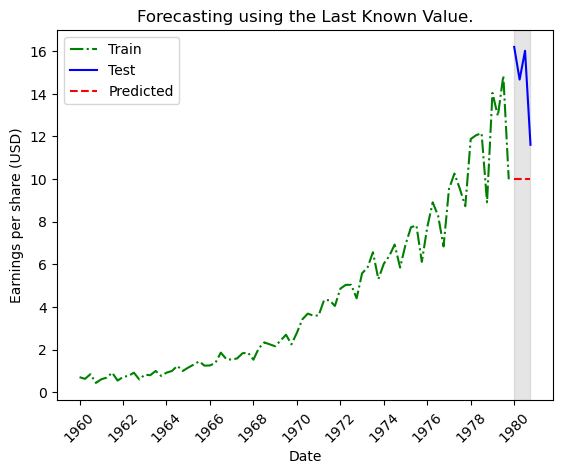

In [23]:
# Plots the forecasting

plt.plot(X_train['date'], X_train['data'], 'g-.', label='Train')
plt.plot(X_test['date'], X_test['data'], 'b-', label='Test')
plt.plot(X_test['date'], X_test['forecast_last_value'], 'r--', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Earnings per share (USD)')
plt.axvspan(80, 83, color='#808080', alpha=0.2)
plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980], rotation=45)
plt.legend()
plt.title("Forecasting using the Last Known Value.")


The new hypothesis with a MAPE of 30.45% did not improve upon the last baseline that was built since and it achieved a MAPE of 15.60%.

### Forecasting using Naive Seasonality

As there is clear cyclical patterns in the data, this component can be considered to build a new baseline model using seasonality. The assumption will be like

_If the EPS is dollar 14.04 for the first quarter of 1979, then the EPS for the first quarter of 1980 will also be dollar 14.04._

In [24]:
# Copies last four values of the train set, which correspond to the four quarters of 1979,
# and assigning them to the corresponding quarters in 1980. 

X_test.loc[:, 'forecast_last_quarter'] = X_train['data'][-4:].values

/tmp/ipykernel_325053/3836507777.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, 'forecast_last_quarter'] = X_train['data'][-4:].values


In [25]:
display(X_test)

,date,data,forecast_mean,forecast_last_year_mean,forecast_last_value,forecast_last_quarter
80,1980-01-01,16.20,4.3085,12.96,9.99,14.04
81,1980-04-01,14.67,4.3085,12.96,9.99,12.96
82,1980-07-02,16.02,4.3085,12.96,9.99,14.85
83,1980-10-01,11.61,4.3085,12.96,9.99,9.99


In [26]:
# Evaluates forecasting performance
last_quarter_mape = mean_absolute_percentage_error(X_test["data"], X_test["forecast_last_quarter"])

print(last_quarter_mape)

0.11561658552433654


Text(0.5, 1.0, 'Forecasting using the Last Quarter Value.')

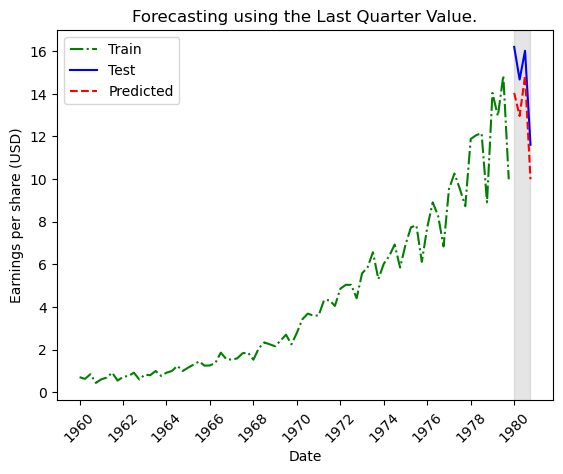

In [27]:
# Plots the forecasting

plt.plot(X_train['date'], X_train['data'], 'g-.', label='Train')
plt.plot(X_test['date'], X_test['data'], 'b-', label='Test')
plt.plot(X_test['date'], X_test['forecast_last_quarter'], 'r--', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Earnings per share (USD)')
plt.axvspan(80, 83, color='#808080', alpha=0.2)
plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980], rotation=45)
plt.legend()
plt.title("Forecasting using the Last Quarter Value.")


This gives us a MAPE of 11.56%, which is the lowest MAPE from all the baselines so far.

Text(0.5, 1.0, 'Performance [MAPE] of the Baselines Models')

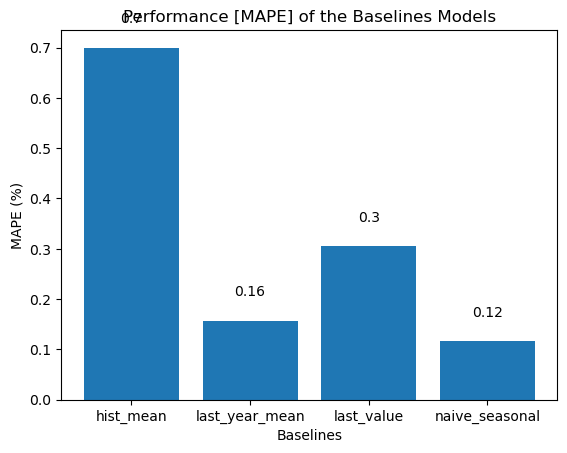

In [28]:
x = ['hist_mean', 'last_year_mean', 'last_value', 'naive_seasonal']
y = [hist_mean_mape, last_year_mean_mape, last_value_mape, last_quarter_mape]

plt.bar(x, y)
plt.xlabel('Baselines')
plt.ylabel('MAPE (%)')

for idx, val in enumerate(y):
    plt.text(x=idx, y=val+0.05, s=round(val, 2), ha="center")
    
plt.title("Performance [MAPE] of the Baselines Models")
plt.tight_layout()
plt.show()

### Observations [IN DRAFT]:

- In general, future values depend on past values, but not those too far back in time. It was evident from the fact that predicting the mean EPS from 1960 to 1979 yielded worse forecasts than predicting the mean EPS over 1979. 

- naive seasonal forecast resulted in the lowest MAPE of all the baselines we built in this chapter. This means that seasonality has a significant impact on future values, since repeating the last season into the future yields fairly accurate forecasts - clearly observe a cyclical pattern being repeated every year in figure - Seasonal effects will have to be considered when we develop a more complex forecasting model

a baseline model serves as a basis for comparison compare the MAPE from a complex model against the MAPE of our naive seasonal forecast. If the MAPE of a complex model is lower than 11.56%, then we’ll know that we have a better-performing model.

### Retrieving & Analyzing the Data

The dataset contains the volume of widget sales for over 500 days starting on January 1, 2019 for a fictitous company. The volume of sales is expressed in thousands of US dollars.

In [29]:
# Loads the dataset
sales = pd.read_csv("../Data/time-series/widget_sales.csv")

# Shows few instances from top
display(sales.head())

,date,widget_sales
0,2019-01-01,50.496714
1,2019-01-02,50.805493
2,2019-01-03,51.477758
3,2019-01-04,53.542228
4,2019-01-05,54.873108


In [30]:
# Shows few instances from bottom
display(sales.tail())

,date,widget_sales
495,2020-05-10,64.087371
496,2020-05-11,63.992081
497,2020-05-12,63.029894
498,2020-05-13,61.671797
499,2020-05-14,59.443839


In [31]:
# Checks the shape of the dataset
print(sales.shape)

(500, 2)


In [32]:
# Checks the descriptive statistics of the dataset
print(sales.describe())

       widget_sales
count    500.000000
mean      46.969858
std       15.382473
min       20.674946
25%       32.507149
50%       47.667536
75%       59.425693
max       82.922496


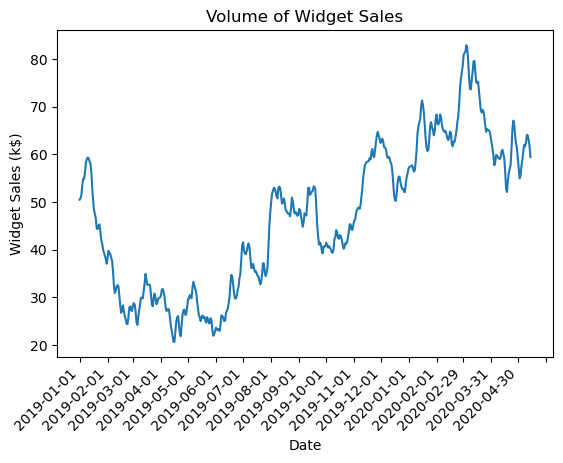

In [33]:
fig, ax = plt.subplots()
ax.plot(sales['date'], sales['widget_sales']) 
ax.set_xlabel('Date')
ax.set_ylabel('Widget Sales (k$)') 
ax.xaxis.set_major_locator(MonthLocator())
#ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.set_title("Volume of Widget Sales")
fig.autofmt_xdate(rotation=45)
plt.show()

The forecasting period is illustrated by the gray zone in above figure.

**Below ones are the findings out of the above figure.**
1. It shows long-term trend with peaks and troughs along with way and hence it is not a stationary time-series.
2. There is no apparent cyclical pattern in the data and hence the effect on seasonality on the forecasting can be ruled out.

In [34]:
# Checks for stationarity using augmented Dickey-Fuller test

sales_adf_results = adfuller(sales["widget_sales"])

print(f"ADF Statistic: {sales_adf_results[0].round(2)}")
print(f"p-Value: {sales_adf_results[1].round(2)}")

ADF Statistic: -1.51
p-Value: 0.53


As the ADF statistic is not a large negative number, and the p-value is greater than 0.05, the time-series is not stationary, and transformations is required to be applied to make it stationary.

In [35]:
# First order differencing is applied to make the series stationary
sales_diff = np.diff(sales["widget_sales"], n=1)

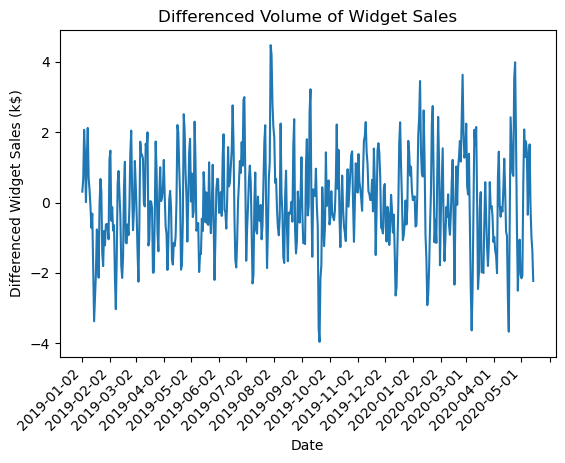

In [36]:
# Plots the differenced series to check if trend component is removed

fig, ax = plt.subplots()
ax.plot(sales['date'][1:], sales_diff) 
ax.set_xlabel('Date')
ax.set_ylabel('Differenced Widget Sales (k$)') 
ax.xaxis.set_major_locator(MonthLocator())
#ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.set_title("Differenced Volume of Widget Sales")
fig.autofmt_xdate(rotation=45)
plt.show()


In [37]:
# Stationarity is once again tested using the ADF test

sales_diff_adf_results = adfuller(sales_diff)

print(f"ADF Statistic: {sales_diff_adf_results[0].round(2)}")
print(f"p-Value: {sales_diff_adf_results[1].round(2)}")

ADF Statistic: -10.58
p-Value: 0.0


With a large negative ADF statistic and a p-value much smaller than 0.05, differenced series is considered to be stationary.

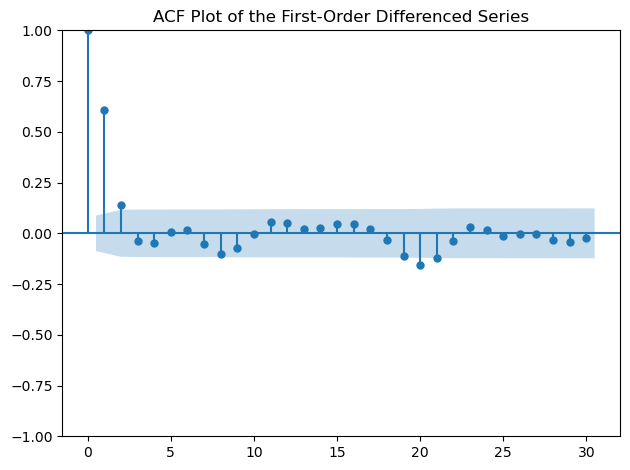

In [39]:
# Plots the ACF of the differenced series

plot_acf(sales_diff, lags=30, title="ACF Plot of the First-Order Differenced Series")
plt.tight_layout()

Followings points were noted out of the above plot.
1. There are significant correlation coefficient up until lag 2 and thereafter the coefficients remained non-significant as shown in the shaded region.
2. It indicates that there is a stationary moving average process of order 2 or MA(2) to forecast the stationary time-series.
3. There are some significant coefficients around lag 20, but this could just due to chance because there are non-significant ones between lag 3 and after lag 20.

### Preparing Datasets

In [40]:
# Stores the sales differences with respect to date into a container
sales_diff_df = pd.DataFrame({"date": sales['date'][1:], "sales_diff": sales_diff})

display(sales_diff_df)

,date,sales_diff
1,2019-01-02,0.308778
2,2019-01-03,0.672265
3,2019-01-04,2.064470
4,2019-01-05,1.330880
5,2019-01-06,0.012034
...,...,...
495,2020-05-10,1.651336
496,2020-05-11,-0.095290
497,2020-05-12,-0.962187
498,2020-05-13,-1.358097


Allocates 90% [449 instances] of the data to the train set and reserve the other 10% [50 instances] for the test set.

In [41]:
X_train = sales_diff_df[:-50]
X_test = sales_diff_df[-50:]

In [42]:
# Prints last and first few timesteps from the train and testset, respectivley, to note the timestep indexes.

display(X_train.tail())

,date,sales_diff
445,2020-03-21,-0.531086
446,2020-03-22,0.577963
447,2020-03-23,-0.409040
448,2020-03-24,-1.249779
449,2020-03-25,-1.803658


In [43]:
display(X_test.head())

,date,sales_diff
450,2020-03-26,-1.170131
451,2020-03-27,0.580967
452,2020-03-28,-0.144902
453,2020-03-29,-0.096564
454,2020-03-30,-0.372334


In [44]:
# Also the shape of the train and testset are shown to note the length of train and testset. 
# First dimension of the trainset shape indicate the length of the horizon.

print(X_train.shape)

(449, 2)


In [45]:
print(X_test.shape)

(50, 2)


In [46]:
# Sets the length (timelines) of the train and testset to be used later

train_len = X_train.shape[0]
test_len = X_test.shape[0]

### Forecasting using Moving Average Process

Forecasting will first be done using naive forecasting techniques as baselines and then using second-order moving average to check if the latter one can outperform the baseline performance.

As MA(_q_) model does not allow us to forecast all timesteps steps (beyond _q_) into the future in one shot, they must therefore be recursively estimated. The following function will predict two timesteps or less at a time, until 50 predictions are made, values of the test set. This method is called rolling forecasts.


In [47]:
def rolling_forecast(data, train_len, horizon, window, method):
    """
        Forecasts for timesteps of length 'window' or less at a time, until all 
        forecasts of length 'horizon' are made
    """    
    
    total_len = train_len + horizon

    if method == "mean":
        prediction_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(data[:i].values)
            prediction_mean.extend(mean for _ in range(window))

        return prediction_mean

    elif method == "last":
        prediction_last_value = []
        
        for i in range(train_len, total_len, window):
            #last_value = data[:i].iloc[-1].values[0]
            last_value = data[:i].iloc[-1]
            prediction_last_value.extend(last_value for _ in range(window))    

        return prediction_last_value

    elif method == "MA":
        prediction_MA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(data[:i], order=(0, 0, 2))
            result = model.fit(disp=False)
            predictions = result.get_prediction(0, i + window - 1)
            oos_predictions = predictions.predicted_mean.iloc[-window:]
            prediction_MA.extend(oos_predictions)

        return prediction_MA


In [48]:
# Creates a container to hold all the differenced forecasts for each method
predictions_diff = X_test.copy()

In [49]:
# Generates differenced forecasts for each method

predictions_diff["prediction_mean"] = rolling_forecast(sales_diff_df["sales_diff"], train_len, test_len, 2, "mean")
predictions_diff["prediction_last_value"] = rolling_forecast(sales_diff_df["sales_diff"], train_len, test_len, 2, "last")
predictions_diff["prediction_MA"] = rolling_forecast(sales_diff_df["sales_diff"], train_len, test_len, 2, "MA")

In [50]:
# Prints forecasts for first few timesteps from all the used methods
display(predictions_diff.head())

,date,sales_diff,prediction_mean,prediction_last_value,prediction_MA
450,2020-03-26,-1.170131,0.034319,-1.803658,-1.078833
451,2020-03-27,0.580967,0.034319,-1.803658,-0.273309
452,2020-03-28,-0.144902,0.032861,0.580967,0.781223
453,2020-03-29,-0.096564,0.032861,0.580967,0.234969
454,2020-03-30,-0.372334,0.032183,-0.096564,0.168994


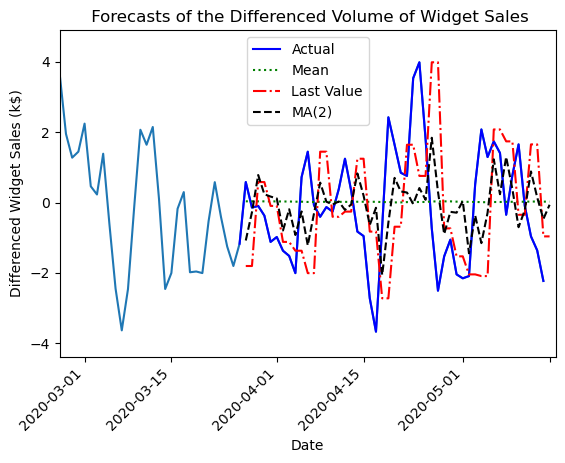

In [51]:
# Visualizes the differenced forecasting of all the used methods over actual differenced target

fig, ax = plt.subplots()
ax.plot(sales_diff_df['date'], sales_diff_df['sales_diff']) 
ax.plot(predictions_diff['date'], predictions_diff['sales_diff'], "b-", label="Actual") 
ax.plot(predictions_diff["prediction_mean"], "g:", label="Mean")
ax.plot(predictions_diff["prediction_last_value"], "r-.", label="Last Value")
ax.plot(predictions_diff["prediction_MA"], "k--", label="MA(2)")

ax.set_xlabel('Date')
ax.set_ylabel('Differenced Widget Sales (k$)') 
ax.xaxis.set_major_locator(AutoDateLocator())
#ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.set_xlim(420, 500)
ax.legend()
ax.set_title(" Forecasts of the Differenced Volume of Widget Sales")
fig.autofmt_xdate(rotation=45)
plt.show()

In [52]:
# Measures the differenced forecasting performance

mse_mean = mean_squared_error(predictions_diff['sales_diff'], predictions_diff['prediction_mean'])
mse_last = mean_squared_error(predictions_diff['sales_diff'], predictions_diff['prediction_last_value'])
mse_MA = mean_squared_error(predictions_diff['sales_diff'], predictions_diff['prediction_MA'])

print(f"MSE for Mean method: {mse_mean.round(2)}")
print(f"MSE for Last Value method: {mse_last.round(2)}")
print(f"MSE for MA(2) method: {mse_MA.round(2)}")

MSE for Mean method: 2.56
MSE for Last Value method: 3.25
MSE for MA(2) method: 1.95


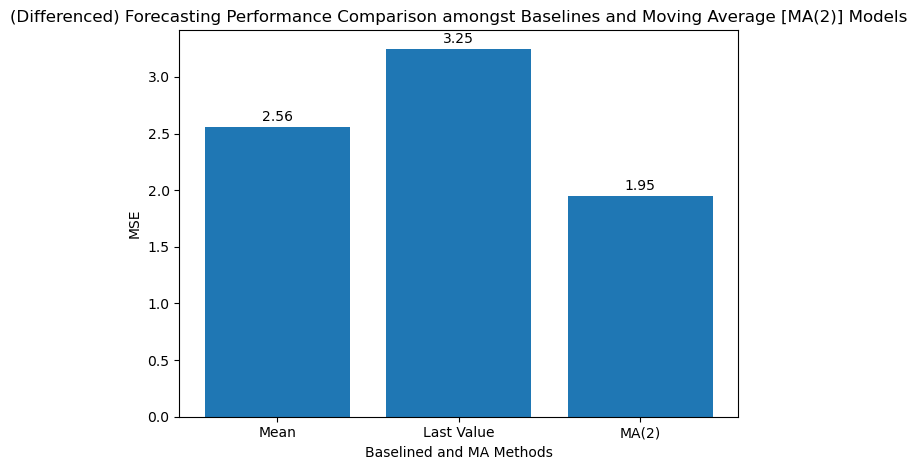

In [53]:
# Visualizes the differenced forecasting performance between all the used methods

x = ['Mean', 'Last Value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

plt.bar(x, y)
plt.xlabel('Baselined and MA Methods')
plt.ylabel('MSE')

for idx, val in enumerate(y):
    plt.text(x=idx, y=val+0.05, s=round(val, 2), ha="center")
    
plt.title("(Differenced) Forecasting Performance Comparison amongst Baselines and Moving Average [MA(2)] Models")

plt.tight_layout()
plt.show()

Once best forecasts for the stationary process are obtained, the forecasts are inverse-transformed (meaning undoing the process of differencing) to bring the forecasts back to their original scale.

In [54]:
# Checks for the actual sales volume at timestep 450 - the first timestep in the horizon to forecast for
sales["widget_sales"].iloc[450]

64.7360049885278

In [55]:
# To inversed-transform, the cumulative sum of differenced forecasts gets added to
# actual sales volume at timesteps 450
sales_predictions = sales["widget_sales"].iloc[450] + predictions_diff["prediction_MA"].cumsum()

In [56]:
# prints forecasting for first few timesteps [starting from 450]
print(sales_predictions[:10])

450    63.657172
451    63.383863
452    64.165086
453    64.400055
454    64.569050
455    64.684860
456    63.889194
457    63.697908
458    62.775084
459    62.521024
Name: prediction_MA, dtype: float64


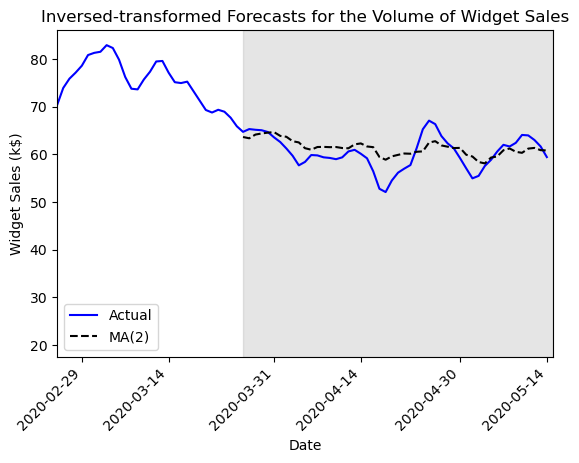

In [57]:
# Visualizes our inversed-transformed (untransformed) predictions against the target (original) data.

fig, ax = plt.subplots()
ax.plot(sales['date'], sales['widget_sales'], "b-", label="Actual") 
ax.plot(sales_predictions, "k--", label="MA(2)") 

ax.set_xlabel('Date')
ax.set_ylabel('Widget Sales (k$)') 
ax.xaxis.set_major_locator(AutoDateLocator())
ax.set_xlim(420, 500)
ax.axvspan(450, 500, color='#808080', alpha=0.2)
ax.legend()
ax.set_title("Inversed-transformed Forecasts for the Volume of Widget Sales")
fig.autofmt_xdate(rotation=45)
plt.show()

In [58]:
rmse_MA = root_mean_squared_error(sales["widget_sales"].iloc[450:], sales_predictions)
mae_MA = mean_absolute_error(sales["widget_sales"].iloc[450:], sales_predictions)

print(f"RMSE: {rmse_MA.round(2)}")
print(f"MAE: {mae_MA.round(2)}")

RMSE: 2.83
MAE: 2.32


### Observations [IN DRAFT]:

[PLACEHOLDER]